[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Disease Identification-Transfer Learning-1

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Tomato-301020-Healthy-zz-V1-20210225103918** and **Tomato-231120-Liriomyza+Tuta absoluta-zz-V1-20210225103715** datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_pytorch_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Control of **plant diseases** is crucial to the reliable production of food, and it provides significant problems in agricultural use of land, water, fuel and other inputs [(Wikipedia)](https://en.wikipedia.org/wiki/Plant_pathology). To mitigate such problems, novel methods are developed that help with diagnosing plant health and identification of diseases. In this tutorial we present a simple implementation of a plant disease identification problem, which can discern amongst healthy and unhealthy samples of Tomato plants. Given the limited availability of data, we will seek to improve our model's performance by retraining a pretrained model on our small dataset.

In this notebook we will manually build an **AlexNet** model and train it from scratch, and then compare its performance against an AlexNet model loaded directly from PT's Hub (or library), pretrained on ImageNet and retrained on our dataset. AlexNet is considered one of the most influential papers published in computer vision, having spurred many more papers published employing CNNs and GPUs to accelerate deep learning. It contains eight layers; the first five were convolutional layers, some of them followed by max-pooling layers, and the last three were fully connected layers. It used the non-saturating ReLU activation function, which showed improved training performance over tanh and sigmoid [(Wikipedia)](https://en.wikipedia.org/wiki/AlexNet).

Feature Extraction is one of the two methods of **Transfer Learning** (the other being Fine-tuning) that we present in this guide, where the weights of the pre-trained architecture are not updated (the layers are frozen). This way, the architecture is used as a feature extractor while the last layer or classifier is trained to make sense of these features in the new problem. Transfer Learning for classification problems is a technique covered by many of our previous notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
3. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb
4. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-4.ipynb
5. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-5.ipynb
6. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-6.ipynb
6. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-7.ipynb

detectdetectdetectdetectdetectdetect**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

## Main Script
### Library Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set PyTorch seed for replicable runs
torch.cuda.manual_seed(747)

# Assert CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

GeForce RTX 2070


### Data Loading

In [3]:
# The data folders are copied to a subfolder so the DataLoader will not load all datasets in the 'eden_data' folder

!mkdir ./eden_data
!cp -a "../eden_library_datasets/Tomato-301020-Healthy-zz-V1-20210225103918/" ./eden_data/
!cp -a "../eden_library_datasets/Tomato-231120-Liriomyza+Tuta absoluta-zz-V1-20210225103715/" ./eden_data/

img_dir = "./eden_data"
NUM_CLASSES = 2

In [4]:
# Declare tensor transformations

transform = {
    "train": transforms.Compose(
        [
            transforms.RandomCrop(227),
            transforms.RandomHorizontalFlip(),
            transforms.Resize([227, 227]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize([227, 227]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [5]:
# Load data from folders

training_data = datasets.ImageFolder(root=img_dir, transform=transform["train"])
test_data = datasets.ImageFolder(root=img_dir, transform=transform["test"])

train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2048, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([194, 3, 227, 227])
Labels batch shape: torch.Size([194])


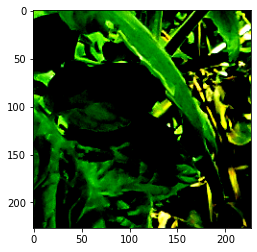

Label: 0


In [6]:
# Display batch dimensions and a sample image

train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

print(f"Label: {label}")

### Auxilliary training functions & parameters

Since no **hyperparameter optimization** is done in this notebook, we only have training and testing subsets, and the terms 'test' and 'validation' can be used interchangeably.

If we were to optimize our hyperparameters, to avoid overfitting, we would be required to have three separate subsets (train/val/test), and validation and testing would be two separate processes. Testing would be run only once, after having settled on the optimum hyperparameters through validation runs, to measure the model's final performance.

In [7]:
# Functions for training and evaluation

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # Load tensors created in CPU to GPU
        if torch.cuda.is_available():
            X = X.to("cuda")
            y = y.to("cuda")

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Training: Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            # Load tensors created in CPU to GPU
            if torch.cuda.is_available():
                X = X.to("cuda")
                y = y.to("cuda")

            # Compute prediction and loss
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
# Set hyperparameters to commonly used values (for AlexNet)

epochs = 5
learning_rate = 0.001
momentum = 0.9
loss_fn = nn.CrossEntropyLoss()

### AlexNet manually built & Trained with limited data

In [9]:
# Define & Load NN

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0, dilation=1, groups=1, bias=True, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False,),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2, dilation=1, groups=1,bias=True, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits


model = NeuralNetwork(num_classes=NUM_CLASSES)
print(model)

if torch.cuda.is_available():
    model.to("cuda")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9

In [10]:
# Start training process

for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_loop(train_dataloader, model, loss_fn, torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum))
    test_loop(test_dataloader, model, loss_fn)

print("Process completed.")

Epoch 1 -------------------------------
Training: Loss: 0.691777  [    0/  194]
Validation: Accuracy: 57.7%, Avg loss: 0.691278 

Epoch 2 -------------------------------
Training: Loss: 0.692219  [    0/  194]
Validation: Accuracy: 56.2%, Avg loss: 0.691801 

Epoch 3 -------------------------------
Training: Loss: 0.691778  [    0/  194]
Validation: Accuracy: 60.8%, Avg loss: 0.691128 

Epoch 4 -------------------------------
Training: Loss: 0.691683  [    0/  194]
Validation: Accuracy: 56.7%, Avg loss: 0.692039 

Epoch 5 -------------------------------
Training: Loss: 0.691510  [    0/  194]
Validation: Accuracy: 56.7%, Avg loss: 0.691408 

Process completed.


### Pretrained AlexNet from PyTorchHub & Retrain with limited data

To actually load the [pretrained AlexNet from PyTorch Hub](https://pytorch.org/hub/pytorch_vision_alexnet/), we would use the line below:<br>
`model_ft = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)`

Unfortunately, while this notebook was being developed PyTorch Hub was experiencing some technical problems, and we loaded the pretrained AlexNet from PT's inbuilt zoo.

In [11]:
# Define & Load NN

model_ft = models.alexnet(pretrained=True)

# Feature Extraction: Freeze layers & replace last layer with trainable layer
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)

if torch.cuda.is_available():
    model_ft.to("cuda")

model_ft.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
# Start training process

for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_loop(train_dataloader, model_ft, loss_fn, torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum))
    test_loop(test_dataloader, model_ft, loss_fn)

print("Process completed.")

Epoch 1 -------------------------------
Training: Loss: 0.785103  [    0/  194]
Validation: Accuracy: 72.2%, Avg loss: 0.621422 

Epoch 2 -------------------------------
Training: Loss: 0.786361  [    0/  194]
Validation: Accuracy: 72.2%, Avg loss: 0.621422 

Epoch 3 -------------------------------
Training: Loss: 0.748630  [    0/  194]
Validation: Accuracy: 72.2%, Avg loss: 0.621422 

Epoch 4 -------------------------------
Training: Loss: 0.762224  [    0/  194]
Validation: Accuracy: 72.2%, Avg loss: 0.621422 

Epoch 5 -------------------------------
Training: Loss: 0.786416  [    0/  194]
Validation: Accuracy: 72.2%, Avg loss: 0.621422 

Process completed.


## Conclusions

Without spending too much time tuning our models, we can see our trained-from-scratch model achieved 60% accuracy on the validation/test set, where the retrained model achieved 72% accuracy. This is a clear indication of the improvements Transfer Learning can bring about in cases of small datasets.

A further hypothesis would be that retraining on a model that has been trained on a large dataset of field-related data, instead of ImageNet, would also offer significant improvements to our model's performance. This related dataset may not necessarily include the same images on what we wish to train on, but merely similar images like crops other than Tomato, as in our case.

## Possible Extensions
1. Use a different NN model.
2. Use hyperparameter optimization (with extra validation subset).
3. Use different, larger datasets, or employ data augmentation techniques to increase dataset size.
4. Pretrain AlexNet model for Feature Extraction on similar agronomical images.

## Bibliography

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/

https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

https://pytorch.org/hub/pytorch_vision_alexnet/

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://cs231n.github.io/transfer-learning/